In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
from skimage import io
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

** TORCH CUDA version installed and working. **
>>> GPU activated? 1


In [2]:
def enlarge_fused_image(fused, patch_height=512, patch_width=512, overlap=256):
    
    '''
    This function makes the fused image larger s.t. an integer number of
    patches fits into it.
    
    INPUTS
    ------
        fused (np array)
        Fused (whole well) image.
        
        overlap (int)
        Overlap of subimages in pixels. Default is 100.
        
        patch_width, patch_height
        Size of patches. Default is 512.
        
    OUTPUTS
    -------
        new_fused (np array)
        Enlarged fused image.
        
        patch_locations (list with 2 elements)
        patch_locations[0] is a numpy array with the y-coordinates of the subimages in pixels.
        patch_locations[1] is a numpy array with the x-coordinates of the subimages in pixels.
    '''
    
    [m,n] = [patch_height, patch_width]
    [M,N,C] = np.shape(fused)
    
    num_m = np.ceil((M - m) / (m - overlap) + 1).astype(int) # number of patches on y-axis
    num_n = np.ceil((N - n) / (n - overlap) + 1).astype(int) # number of patches on x-axis

    new_M = (num_m - 1) * (m - overlap) + m # new fused image height
    new_N = (num_n - 1) * (n - overlap) + n # new fused image width
    
    new_fused = np.zeros([new_M,new_N,C], dtype='uint8')
    new_fused[0:M,0:N,:] = fused
    
    patch_locations = []
    patch_locations.append(np.arange(0,new_M-m+1,m-overlap)) # y-locations of patches (in pixels)
    patch_locations.append(np.arange(0,new_N-n+1,n-overlap)) # x-locations of patches (in pixels)
    
    return [new_fused, patch_locations]

def fused_to_patches(fused, patch_locations, patch_height=512, patch_width=512):
    '''
    This function takes as input an (enlarged) fused image.
    It outputs a list of patches which are ordered in a column-to-column grid.
    The locations of the patches in the fused image are specified by patch_locations.
    '''
    [n,m] = [patch_height, patch_width]
    patch_list = []
    for c_n in patch_locations[1]:     # c_n is n-coordinate in pixels
        for c_m in patch_locations[0]: # c_m is m-coordinate in pixels
            patch = fused[c_m:c_m+m,c_n:c_n+n,:]
            patch_list.append(patch)
    
    return patch_list

In [3]:
def find_edges(mask):
    '''
    This function finds the edges of labeled objects in the mask.
    '''

    padded_mask = np.pad(mask,1,mode='edge')

    center = padded_mask[1:-1,1:-1]
    up = padded_mask[0:-2,1:-1]
    up_left = padded_mask[0:-2,0:-2]
    left = padded_mask[1:-1,0:-2]

    compare = np.array((center!=up,center!=up_left,center!=left))
    edges = np.logical_or.reduce(compare)
    
    return edges

def split_cells_on_mask(mask):
    '''
    This function separates objects on the mask
    based on edges.
    '''
    edges = find_edges(mask)
    compare = np.array((mask > 0, ~edges))
    segmented_mask = np.logical_and.reduce(compare)
    
    return segmented_mask

In [4]:
def calculate_img_similarity(img1, img2):
    '''
    This function calculates what percentage of
    img1 and img2 are the same.
    Img1 and img2 are boolean images.
    '''
    equal_pixels = np.logical_and(img1,img2)
    return np.sum(equal_pixels) / min([np.sum(img1), np.sum(img2)])

def find_cell_values_which_overlap(cell_on_overlap, combined_overlap, similarity_threshold):
    '''
    This function finds which cells on the combined_overlap image
    overlap with the boolean image cell_on_overlap.
    '''
    overlapping_cell_values = cell_on_overlap * combined_overlap
    unique = np.unique(overlapping_cell_values)
    values_with_sufficient_overlap = []
    
    # loop through cells which overlap with the cell on the egde
    # and calculate similarity
    for overlapping_value in unique[1:]:
        cell_on_mask = (combined_overlap==overlapping_value)
        if calculate_img_similarity(cell_on_mask, cell_on_overlap) > similarity_threshold:
            values_with_sufficient_overlap.append(overlapping_value)
            
    return values_with_sufficient_overlap

In [5]:
def store_overlapping_cells(values_on_edge, patch_ol, combined_ol, similarity_threshold):
    '''
    This function stores which cells on combined_ol overlap with the
    cells in the edge region of patch_ol (in a dictionary).
    Keys in the 'overlap_dict' dictionary are the values of cells which lie
    in the edge region of patch_ol.
    Corresponding values are the cells on combined_ol which sufficiently
    overlap with the cells.
    Example: overlap_dict = {23: [34,45]}
             means that there is a cell (nr 23) on path_ol in the edge region.
             It overlaps with cells 34 and 45. These are probably two half cells.
    '''
    # Initialise dictionary to store old and new values
    overlap_dict = {}
    # Collect values to be removed in the replace dictionary
    for value in values_on_edge:
        cell_shape = (patch_ol == value)
        values_overlapping = find_cell_values_which_overlap(cell_shape, combined_ol, similarity_threshold)
        overlap_dict[value] = values_overlapping   
        
    return overlap_dict

def replace_overlapping_cells(overlap_dict, patch_ol, combined_ol, max_value):
    '''
    This function replaces cells on the edge of combined_ol with 
    overlapping cells on the edge of patch_ol.
    The cells on patch_ol are correctly predicted, so they should
    replace the wrongly predicted cells on combined_ol.
    '''
    combined_ol_new = np.copy(combined_ol)
    for value, values_to_remove in overlap_dict.items():
        # remove value which overlaps with a cell on patch_ol
        for old_value in values_to_remove:
            combined_ol_new[np.where(combined_ol_new==old_value)] = 0
        # add the cells on mask_ol to the image
        if len(values_to_remove) > 0:     
            max_value = max_value + 1
            combined_ol_new[np.where(patch_ol==value)] = max_value
            
    return combined_ol_new

In [6]:
def align_patches(patch1, patch2, patch_ol, edge_thickness, similarity_threshold, axis):
    
    '''
    This function aligns patch1 and patch2 based on the overlap patch_ol.
    '''
    
    m,n = np.shape(patch1)
    edge_size = int(edge_thickness/2)
    
    # Increase cell values on patch2 with the max value of patch1
    patch2[np.where(patch2>0)] = patch2[np.where(patch2>0)] + np.max(patch1)
    # Get max value (values of new overlapping cells are always larger than max_value)
    max_value = np.max(patch2)
    
    # Get a list of cells that lie on the edge region of the overlapping patch (values_on_edge)
    # Create combined overlap by pasting the 2 patches together (combined_ol)
    if (axis==0):
        center = int(m / 2)
        values_on_edge = np.unique( patch_ol[center-edge_size:center+edge_size+1,:] )
        combined_ol = np.concatenate([patch1[center:m,:],patch2[0:center,:]],axis=0)
    elif (axis==1):
        center = int(n / 2)
        values_on_edge = np.unique( patch_ol[:,center-edge_size:center+edge_size+1] )
        combined_ol = np.concatenate([patch1[:,center:n],patch2[:,0:center]],axis=1)
    else:
        raise ValueError('Invalid choice for axis. Please choose either 0 or 1.')
    
    # Remove 0 (=background) from the list
    values_on_edge = np.delete(values_on_edge, np.where(values_on_edge==0))    

    # Find overlapping cells 
    overlap = store_overlapping_cells(values_on_edge, patch_ol, combined_ol, similarity_threshold)
    combined_ol_new = replace_overlapping_cells(overlap, patch_ol, combined_ol, max_value)
    
    # Update patches
    if (axis==0):
        patch1_new = np.concatenate([patch1[0:center,:],combined_ol_new[0:center,:]],axis=0)
        patch2_new = np.concatenate([combined_ol_new[center:m,:],patch2[center:m,:]],axis=0)
    elif (axis==1):
        patch1_new = np.concatenate([patch1[:,0:center],combined_ol_new[:,0:center]],axis=1)
        patch2_new = np.concatenate([combined_ol_new[:,center:n],patch2[:,center:n]],axis=1)
    
    return patch1_new, patch2_new

In [7]:
def remove_small_cells(fused_mask, cell_size_threshold):
    '''
    This function removes cells smaller than cell_size_threshold.
    '''
    # Separate cells on fused mask
    separated_cells = split_cells_on_mask(fused_mask)

    # Remove cells smaller than cell_size_threshold
    label_objects, nb_labels = ndi.label(separated_cells)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > cell_size_threshold
    mask_sizes[0] = 0
    filtered_cells = mask_sizes[label_objects]

    # Label again
    filtered_fused_mask, nb_labels = ndi.label(filtered_cells)
    
    return filtered_fused_mask

In [8]:
def create_overlapping_columns(mask_list, patch_locations, edge_thickness, similarity_threshold):

    num_patches_mm = np.size(patch_locations[0])
    num_patches_nn = np.size(patch_locations[1])
    overlapping_columns = []

    # loop over all columns
    for nn in range(0, num_patches_nn):

        print('Aligning patches in column ',nn,'...')
        patches_in_column = []

        # loop over rows in steps of 2 (avoid the last patch in column)
        for mm in range(0,num_patches_mm-1,2):

            # Get patch1, patch2 and patch_ol
            patch_nr = nn * num_patches_mm + mm
            if mm==0: # if we are at the top of the column
                patch1 = np.copy(mask_list[patch_nr])        # patch1 (upper patch) is new patch from patch_list
                patches_in_column.append(patch1)
            else:
                patch1 = np.copy(patches_in_column[-1])       # patch1 (upper patch) is previously processed patch
            patch2 = np.copy(mask_list[patch_nr + 2])         # patch2 is lower patch
            patch_ol = np.copy(mask_list[patch_nr + 1])       # patch_ol is overlapping patch

            # Align patch1 and patch2 using overlap
            patch1_new,patch2_new = align_patches(patch1, patch2, patch_ol, edge_thickness, similarity_threshold, axis=0)
            patches_in_column[-1] = patch1_new     # overwrite first patch
            patches_in_column.append(patch2_new)   # append new patch

        # Combine patches into a column
        aligned_patches = np.concatenate(patches_in_column,axis=0)
        overlapping_columns.append(aligned_patches)
        
    return overlapping_columns

In [9]:
def align_overlapping_columns(overlapping_columns, edge_thickness, similarity_threshold):
    
    num_columns = len(overlapping_columns)
    aligned_columns = []

    # loop over columns in steps of 2 (avoiding the last one)
    for nn in range(0,num_columns-1,2):

        print('Aligning columns ', nn, ' and ',nn+2,'...')

        # Get patch1, patch2 and patch_ol
        if nn==0:
            patch1 = np.copy(overlapping_columns[nn])  # first column
            aligned_columns.append(patch1)
        else:
            patch1 = np.copy(aligned_columns[-1])      # left column
        patch2 = np.copy(overlapping_columns[nn+2])    # right column
        patch_ol = np.copy(overlapping_columns[nn+1])  # overlapping column

        # Align patch1 and patch2 using overlap
        patch1_new,patch2_new = align_patches(patch1, patch2, patch_ol, edge_thickness, similarity_threshold, axis=1)

        aligned_columns[-1] = patch1_new    # overwrite left column
        aligned_columns.append(patch2_new)  # append right column
        
    return aligned_columns


In [10]:
def segment_fused_image_with_cellpose(path_to_well_folder, well, diameter, channels,
                                      edge_thickness=60, similarity_threshold=0.8,
                                      cell_size_threshold=100, patch_height=512, patch_width=512):

    overlap = int(512/2)

    # Read fused image and enlarge it
    fused_path = os.path.join(path_to_well_folder, well+'_fused_RGB.tif')
    fused = io.imread(fused_path)
    [M,N,C] = np.shape(fused)
    [new_fused, patch_locations] = enlarge_fused_image(fused, patch_height=patch_height, patch_width=patch_width, overlap=overlap)

    # Make a list of patches
    patch_list = fused_to_patches(new_fused, patch_locations)
    print('Number of patches to predict: %d'%len(patch_list))

    # Predict patches with cellpose
    model = models.Cellpose(gpu=use_GPU, model_type='cyto')
    mask_list, flows, styles, diams = model.eval(patch_list, diameter=diameter, flow_threshold=None, channels=channels)

    # Align vertical patches into overlapping columns
    overlapping_columns = create_overlapping_columns(mask_list, patch_locations, edge_thickness, similarity_threshold)
    # Align overlapping columns
    aligned_columns = align_overlapping_columns(overlapping_columns, edge_thickness, similarity_threshold)

    # Combine overlapping columns into a fused_mask
    fused_mask = np.concatenate(aligned_columns, axis=1)
    fused_mask = fused_mask[0:M,0:N]

    # Remove cells smaller than cell_size_threshold
    filtered_fused_mask = remove_small_cells(fused_mask, cell_size_threshold)

    return filtered_fused_mask

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)
time spent: running network 0.38s; flow+mask computation 0.22
estimated masks for 1 image(s) in 0.66 sec
>>>> TOTAL TIME 0.66 sec


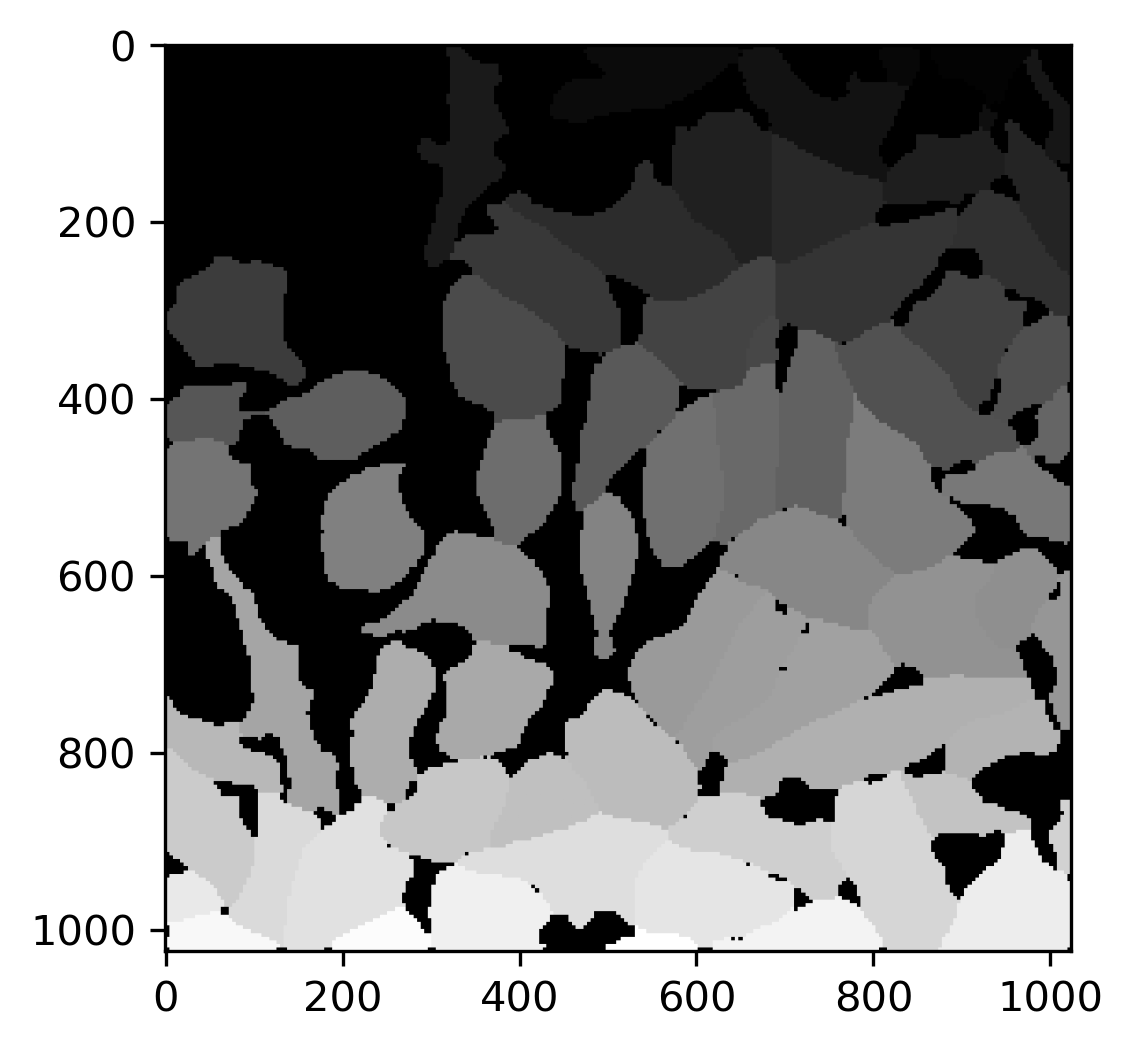

In [35]:
root = r'M:/tnw/bn/dm/Shared/Lukas/Experiments/WKS024/20x/B02'
path = os.path.join(root, 'test5.tif')
# Predict patches with cellpose
diameter = 125
channels = [1,3] # R=cytoplasm and G=nucleus
patch_list = io.imread(path)
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
mask_list, flows, styles, diams = model.eval(patch_list, diameter=diameter, flow_threshold=None, channels=channels)

plt.figure()
plt.imshow(mask_list,cmap='gray')

C:\Users\lukasvandenheu\Anaconda3\envs\cellpose\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


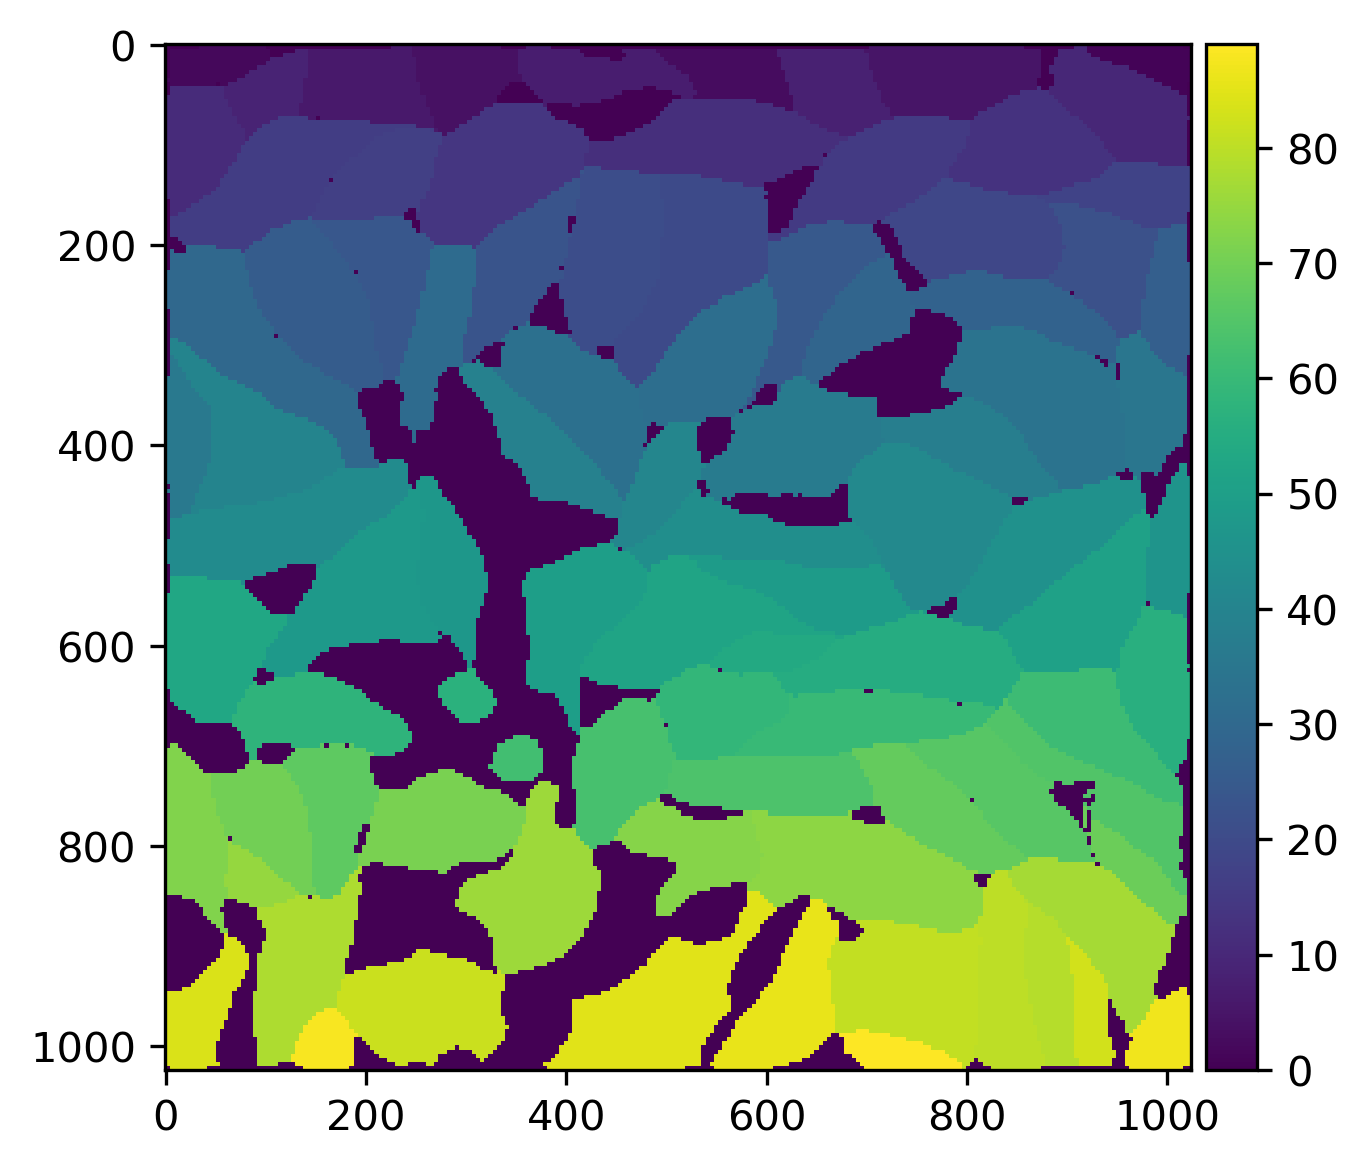

In [13]:
# experiment = 'WKS024'
# magnification = '10x'
import os

well = 'B02'
root = r'M:\tnw\bn\dm\Shared\Lukas\NetworkAnalysis\CellContactNetwork\Cellpose'
well_folder = os.path.join(root,well)
[patch_height, patch_width] = [512,512]
edge_thickness = 60 # pixels
similarity_threshold = 0.8
cell_size_threshold = 100 # minimal cell size in pixels

# Cellpose parameters
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
# ---------------------------------------------------------------------------------
diameter = 97
channels = [1,2] # R=cytoplasm and G=nucleus

segmented = segment_fused_image_with_cellpose(root, well, diameter, channels,
                                              edge_thickness=edge_thickness, similarity_threshold=similarity_threshold,
                                              cell_size_threshold=cell_size_threshold, patch_height=patch_height, patch_width=patch_width)

output_path = os.path.join(well_folder, well+'_fused_mask.tif')
io.imshow(segmented)
io.imsave(output_path, segmented)

Number of subimages to predict: 961
** TORCH CUDA version installed and working. **
>>>> using GPU
processing 961 image(s)


C:\Users\lukasvandenheu\Anaconda3\envs\cellpose\lib\site-packages\cellpose\transforms.py:234: UserWarning: chan to seg' has value range of ZERO
  warnings.warn("chan to seg' has value range of ZERO")
C:\Users\lukasvandenheu\Anaconda3\envs\cellpose\lib\site-packages\cellpose\transforms.py:236: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn("'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0")
C:\Users\lukasvandenheu\Anaconda3\envs\cellpose\lib\site-packages\cellpose\transforms.py:186: RuntimeWarning: divide by zero encountered in true_divide
  X = (X - np.percentile(X, 1)) / (np.percentile(X, 99) - np.percentile(X, 1))
C:\Users\lukasvandenheu\Anaconda3\envs\cellpose\lib\site-packages\cellpose\transforms.py:186: RuntimeWarning: invalid value encountered in true_divide
  X = (X - np.percentile(X, 1)) / (np.percentile(X, 99) - np.percentile(X, 1))
  0%|                                                                            

time spent: running network 280.49s; flow+mask computation 123.65
estimated masks for 961 image(s) in 417.29 sec
>>>> TOTAL TIME 417.29 sec
Aligning patches in column  0 ...
Aligning patches in column  1 ...
Aligning patches in column  2 ...
Aligning patches in column  3 ...
Aligning patches in column  4 ...
Aligning patches in column  5 ...
Aligning patches in column  6 ...
Aligning patches in column  7 ...
Aligning patches in column  8 ...
Aligning patches in column  9 ...
Aligning patches in column  10 ...
Aligning patches in column  11 ...
Aligning patches in column  12 ...
Aligning patches in column  13 ...
Aligning patches in column  14 ...
Aligning patches in column  15 ...
Aligning patches in column  16 ...
Aligning patches in column  17 ...
Aligning patches in column  18 ...
Aligning patches in column  19 ...
Aligning patches in column  20 ...
Aligning patches in column  21 ...
Aligning patches in column  22 ...
Aligning patches in column  23 ...
Aligning patches in column  24

NameError: name 'filtered_fused_mask' is not defined

In [ ]:
# make naive fused mask (for debugging)
M,N,C = np.shape(new_fused)
fused_mask_naive = np.zeros((M,N))

[m,n] = [patch_height, patch_width]

for nn in range(0,num_patches_nn,2):
    
    c_n = patch_locations[1][nn]
    
    for mm in range(0,num_patches_mm,2):
        c_m = patch_locations[0][mm]
        nr = nn * num_patches_mm + mm
        fused_mask_naive[c_m:c_m+m, c_n:c_n+n] = mask_list[nr]
        

io.imsave(well+'_fused_mask_naive.tif', fused_mask_naive)

In [ ]:
io.imshow(aligned_columns[7][2200:2600,:])
#io.imshow(aligned_columns[7])

In [ ]:
io.imshow(overlapping_columns[14][2200:2600,:])

In [ ]:
io.imshow(overlapping_columns[15][2200:2600,:],cmap='flag')

In [ ]:
patch1 = np.copy(overlapping_columns[14])      # left column
patch2 = np.copy(overlapping_columns[16])    # right column
patch_ol = np.copy(overlapping_columns[15])  # overlapping column
edge_thickness = 60
# Align patch1 and patch2 using overlap
patch1_new,patch2_new = align_patches(patch1, patch2, patch_ol, edge_thickness, similarity_threshold, axis=1)

#aligned_columns[-1] = patch1_new    # overwrite left column
#aligned_columns.append(patch2_new)  # append right column

io.imshow(patch1_new)